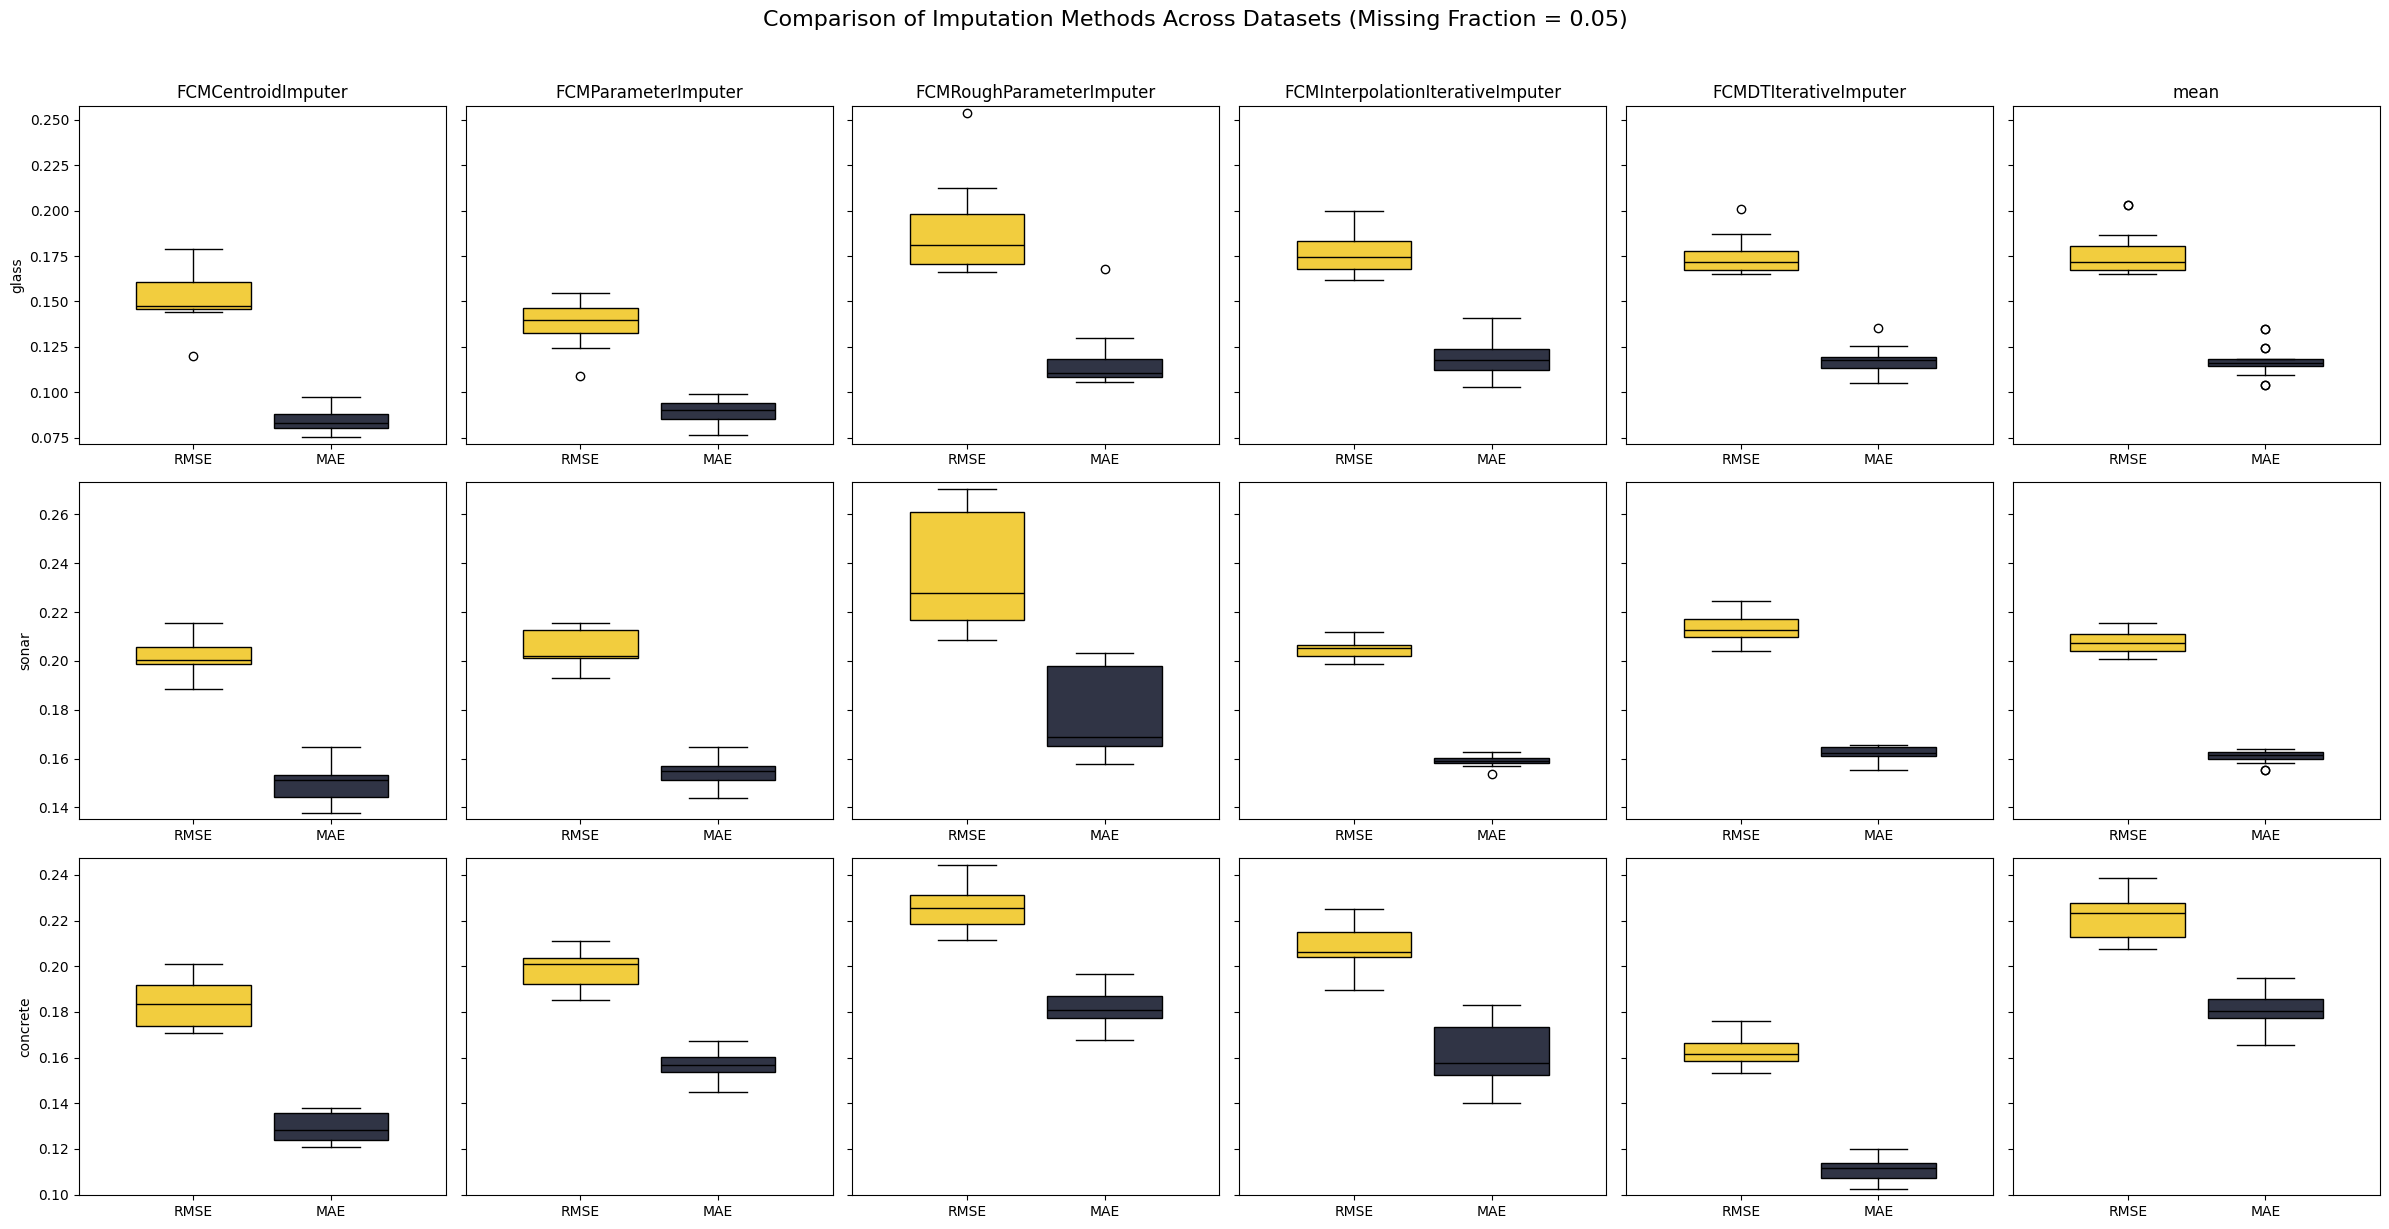

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder1 = "01_MI_results"
folder2 = "01_MI_results_2"
datasets = ["glass", "sonar", "concrete"]  
missing_fraction = 0.05
imputers_order = ["FCMCentroidImputer", "FCMParameterImputer", "FCMRoughParameterImputer",
                   "FCMInterpolationIterativeImputer", "FCMDTIterativeImputer", "mean"]

colors = {"RMSE": "#f2cd3e", "MAE": "#303445"}

all_data = []

for dataset in datasets:
    path1 = os.path.join(folder1, f"{dataset}.csv")
    path2 = os.path.join(folder2, f"{dataset}.csv")
    
    df1 = pd.read_csv(path1)
    df2 = pd.read_csv(path2)
    
    df1 = df1[df1["Missing Fraction"] == missing_fraction]
    df2 = df2[df2["Missing Fraction"] == missing_fraction]
    
    df2_renamed = df2.rename(columns={col: f"{col}_2" for col in df2.columns if col not in ["Dataset","Repeat_ID","Missing Fraction"]})
    
    df_merged = pd.merge(df1, df2_renamed, on=["Dataset", "Repeat_ID", "Missing Fraction"])
    df_merged["Dataset_name"] = dataset
    all_data.append(df_merged)

data = pd.concat(all_data, ignore_index=True)

n_datasets = len(datasets)
n_methods = len(imputers_order)

all_values = []

# for dataset in datasets:
#     df_dataset = data[data["Dataset_name"] == dataset]
#     for imputer in imputers_order:
#         rmse_cols = [col for col in df_dataset.columns if imputer in col and "_RMSE" in col]
#         mae_cols = [col for col in df_dataset.columns if imputer in col and "_MAE" in col]
#         all_values.extend(df_dataset[rmse_cols].values.flatten())
#         all_values.extend(df_dataset[mae_cols].values.flatten())

# y_min, y_max = min(all_values), max(all_values)
# y_margin = (y_max - y_min) * 0.02  
# y_limits = (y_min - y_margin, y_max + y_margin)

y_limits_dict = {}

for dataset in datasets:
    df_dataset = data[data["Dataset_name"] == dataset]
    all_values = []

    for imputer in imputers_order:
        rmse_cols = [col for col in df_dataset.columns if imputer in col and "_RMSE" in col]
        mae_cols = [col for col in df_dataset.columns if imputer in col and "_MAE" in col]
        all_values.extend(df_dataset[rmse_cols].values.flatten())
        all_values.extend(df_dataset[mae_cols].values.flatten())
    
    y_min, y_max = min(all_values), max(all_values)
    y_margin = (y_max - y_min) * 0.02  # np. 2% margines
    y_limits_dict[dataset] = (y_min - y_margin, y_max + y_margin)

fig, axes = plt.subplots(n_datasets, n_methods, figsize=(4*n_methods, 4*n_datasets), sharex=False)

for i, dataset in enumerate(datasets):
    df_dataset = data[data["Dataset_name"] == dataset]
    
    for j, imputer in enumerate(imputers_order):
        ax = axes[i, j] if n_datasets > 1 else axes[j]
        
        rmse_cols = [col for col in df_dataset.columns if imputer in col and "_RMSE" in col]
        mae_cols = [col for col in df_dataset.columns if imputer in col and "_MAE" in col]
        
        rmse_values = df_dataset[rmse_cols].values.flatten()
        mae_values = df_dataset[mae_cols].values.flatten()
        
        positions = [1, 1.6]
        medianprops = dict(color='black', linewidth=1)
        b1 = ax.boxplot(rmse_values, positions=[positions[0]], widths=0.5, patch_artist=True, medianprops=medianprops)
        b2 = ax.boxplot(mae_values, positions=[positions[1]], widths=0.5, patch_artist=True, medianprops=medianprops)
        
        for patch in b1['boxes']:
            patch.set_facecolor(colors["RMSE"])
        for patch in b2['boxes']:
            patch.set_facecolor(colors["MAE"])
        
        ax.set_xlim(0.5, 2.1)
        ax.set_xticks([1, 1.6])
        ax.set_xticklabels(["RMSE","MAE"], rotation=0)
        
        ax.set_ylim(y_limits) 
        if j == 0:
            ax.set_ylabel(dataset)
            ax.set_ylim(y_limits_dict[dataset])
            # ax.set_ylim(y_limits)
        else:
            ax.set_yticklabels([]) 
            ax.set_ylim(y_limits_dict[dataset])
            # ax.set_ylim(y_limits)
        
        if i == 0:
            ax.set_title(imputer, rotation=0, ha="center")
        if j == 0:
            ax.set_ylabel(dataset)
        else:
            ax.set_ylabel("")
fig.suptitle(
    "Comparison of Imputation Methods Across Datasets (Missing Fraction = 0.05)",
    fontsize=16,     
    y=1.02          
)
plt.tight_layout()
plt.show()